In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np

In [2]:
with open("results/metrics_details.json") as f:
    data = json.load(f)

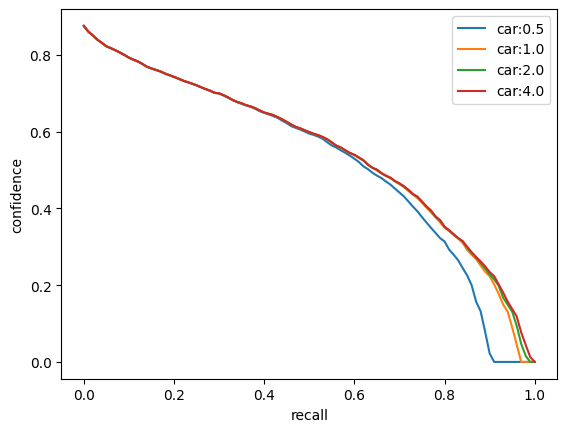

In [3]:
keys = ["car:0.5", "car:1.0", "car:2.0", "car:4.0"]
for k, d in ((key, data[key]) for key in keys):
    plt.plot(d["recall"], d["confidence"], label=k)
plt.ylabel('confidence')
plt.xlabel('recall')
plt.legend()

Text(0.5, 0, 'recall')

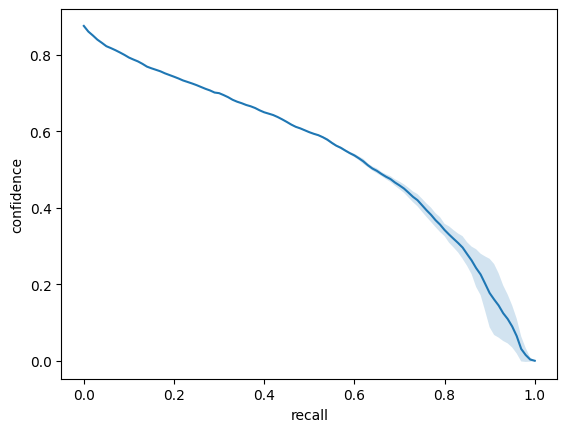

In [4]:
# Compute the mean and std of the confidence for each recall value over keys
mean = np.stack([data[key]["confidence"] for key in keys]).mean(axis=0)
std = np.stack([data[key]["confidence"] for key in keys]).std(axis=0)

# Plot the mean and std as a shaded area
plt.fill_between(data[keys[0]]["recall"], mean - std, mean + std, alpha=0.2)
plt.plot(data[keys[0]]["recall"], mean, label="mean")
plt.ylabel('confidence')
plt.xlabel('recall')